In [4]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import scipy.io
from scipy.stats import multivariate_normal
import os
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

plt.set_cmap('jet')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<Figure size 432x288 with 0 Axes>

# Overview

In this notebook, we will explore how to force linear correlation between the SGWB map and the CMB map. In the document `SGWB_coherence`, Brendan has already constructed a simulation that explores the scenario where there is no correlation between them, and finds the distribution of 10,000 simulated coherence values.

Here, we force correlation by virtue of some $\lambda$ coefficient on the CMB map, where $\lambda$ is the strength of the correlation. When we vary this $\lambda$, we expect to see different distributions of the coherence.

Currently, our process is that we are calculating the coherence between the SGWB map and the CMB map. Define these as $M_G$ and $M_C$ respectively. Then:

Reminder that the coherence is defined as:

$$ \Gamma(M_G, M_C) = \frac{\langle \delta M_{G} \delta M_{C} \rangle^2}{\langle \delta M_{G}^2 \rangle \langle \delta M_{C}^2 \rangle} $$

$$M_{G+C} = M_G + \lambda M_C$$

We want to find the coherence $\Gamma(M_G, M_{G+C})$ after creating the new map above with the forced correlation $\lambda$.

In [5]:
# import alm's from SGWB map
matfile = scipy.io.loadmat("O2_plots_a2_20-500Hz_h0.68_L15.mat")

# import CMB map
cmb_map = hp.read_map("COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=0)
NSIDE = hp.get_nside(cmb_map)

In [6]:
cmb_map.shape

(50331648,)

In [7]:
# info about matfile
# alms stored in p0
# cov of alms stored in pCovar0
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'bad_jobs', 'bad_segs', 'nsegs', 'alpha', 'fref', 'lmax', 'L', 'h0', 'str', 'matdir', 'plotdir', 'pproc_filename', 'prefix', 'bias_fac', 'cov_effect', 'conf', 'calErr', 'None', 'Fisher', 'Y', 'X', 'sigmaY', 'hstr', 'H0', 'omega', 'omega_sig', 'Ntot', 'fkeep', 'Nkeep', 'regMethod', 'x0', 'fisher0', 'invfisher0', 'pCovar0', 'egmod', 'U', 'eg', 'V', 'pCovar_UL', 'p0', 'Cl', 'Cl_sig', 'res', 'map0', 'ra', 'decl', 'sigma0', 'sigmaPix0', 'RA', 'DECL', 'dOmg', 'sigmaPix_UL', 'dirty', 'd', 'dirty_sigma', 'max_snr', 'min_snr', 'ul0', 'ul_test', 'sphmat', 'avgSNR', '__function_workspace__'])

In [8]:
print('lmax:',matfile['lmax'])
print('alm shape', matfile['p0'].shape)
print('cov alm shape', matfile['pCovar0'].shape)

lmax: [[15]]
alm shape (256, 1)
cov alm shape (256, 256)


In [9]:
# process alms
alm = matfile['p0'].reshape(256)
cov_alm = matfile['pCovar0']
lmax = 15

# skip these alm's, don't know why but Brendan did it
skip = int(lmax*(lmax+1)/2)
alm = alm[skip:]
cov_alm = cov_alm[skip:,skip:]
print(cov_alm.shape, alm.shape)

(136, 136) (136,)


In [10]:
# create sgwb map from alm
sgwb_map = hp.alm2map(alms=alm, nside=NSIDE, lmax=lmax)

In [11]:
# confirm dimensions are same on pixel basis
print(sgwb_map.shape == cmb_map.shape)

True


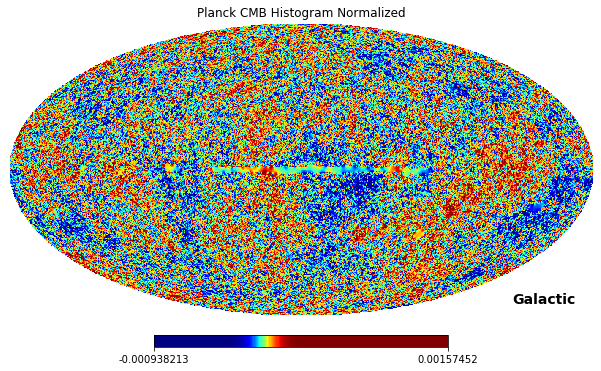

In [12]:
# visualize CMB map
hp.mollview(cmb_map, coord='G', title = 'Planck CMB Histogram Normalized', norm='hist')

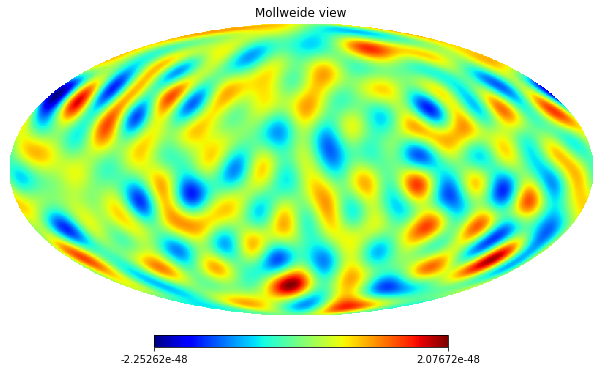

In [13]:
# visualize SGWB map
hp.mollview(sgwb_map)

# Simulation

Multiple functions are defined in this part.

First, we define functions `C2Rcov` and `complex_mvn_rvs` (courtesy of Kate and Angelo). We take in the covariance matrix for the $a_{lm}$ and output the real covariance matrix for the corresponding $a_{lm}$. We then simulate using the complex multivariate normal distribution in the `simulate_sgwb` function which returns a healpy map of the alms.

Then, we can calculate coherence of two maps using the `calculate_coherence` function, which takes in the two maps and outputs coherence. I have adapted Brendan's function to include a `lambda` parameter, which is meant to indicate the strength of the correlation between the maps.

In [14]:
def C2Rcov(covmat): #input: complex covariance matrix
    size=len(covmat)
    lmax=int(size**0.5) -1
    #print(size)
    #print(lmax)
    ll2,mm2=hp.Alm.getlm(lmax)
    ll1=np.flip(ll2[(lmax+1):])
    mm1=-1*np.flip(mm2[(lmax+1):])
    ll=np.concatenate((ll1,ll2))
    mm=np.concatenate((mm1,mm2))
    Rcovmat=np.zeros((2*size,2*size))
    for ii in range(size):   # -m
        for jj in range(size):
            p=ll[ii]
            q=mm[ii]
            l=ll[jj]
            m=mm[jj]
            #R_pq R_lm
            Rcovmat[ii][jj]=0.25*(covmat[ii][jj] + ((-1)**abs(q))*covmat[size-1-ii][jj] + ((-1)**abs(m))*covmat[ii][size-1-jj] + ((-1)**abs(q+m))*covmat[size-1-ii][size-1-jj])
            #I_pq I_lm
            Rcovmat[ii+size][jj+size]=0.25*(covmat[ii][jj] - ((-1)**abs(q))*covmat[size-1-ii][jj] - ((-1)**abs(m))*covmat[ii][size-1-jj] + ((-1)**abs(q+m))*covmat[size-1-ii][size-1-jj])
            #R_pq I_lm
            Rcovmat[ii][jj+size]=0.25*(-1j)*(covmat[ii][jj] + ((-1)**abs(q))*covmat[size-1-ii][jj] - ((-1)**abs(m))*covmat[ii][size-1-jj] - ((-1)**abs(q+m))*covmat[size-1-ii][size-1-jj])
            #I_pq R_lm
            Rcovmat[ii+size][jj]=0.25*(1j)*(covmat[ii][jj] - ((-1)**abs(q))*covmat[size-1-ii][jj] + ((-1)**abs(m))*covmat[ii][size-1-jj] - ((-1)**abs(q+m))*covmat[size-1-ii][size-1-jj])                
    return Rcovmat

In [15]:
## get converted alm matrix
full_cov_alms = matfile['pCovar0']
converted_alm_cov = C2Rcov(full_cov_alms)

In [16]:
converted_alm_cov.shape

(512, 512)

In [17]:
def complex_mvn_rvs(covmatrix, lmax, size=1, mean = 0, random_state=None):
        cov = covmatrix
        
        #here we determine the length N, which is how long the a_lm list should be:
        halflength = np.int(cov.shape[1]/2)
        
        #below we generate the 2N long multivariate normal sample:
        xy_rvs = multivariate_normal.rvs(random_state=random_state,
                                         cov=cov)
        
        #here we split the 2N long sample vector into N complex vector
        temporaryalms =  xy_rvs[0:halflength] + 1j * xy_rvs[halflength:] + mean
        skip = int(lmax*(lmax+1)/2)
        
        #here we return the lmax subset of the sample:
        return(temporaryalms[skip:])

In [18]:
test = complex_mvn_rvs(converted_alm_cov, lmax = 15)
test.shape ## vector of length 136, matches original skipped alm vec

(136,)

In [19]:
def simulate_sgwb(cov_mat, NSIDE, lmax=15):
    '''
    Input: cov_mat takes in the converted a_lm matrix
           NSIDE is the desired num of sides for the map (per healpy def'n)
           lmax is lmax
    Output: simulated healpy map
    '''
    ## simulate based on generated covariance matrix
    sim_alm = complex_mvn_rvs(cov_mat, lmax=lmax)
    
    ## convert simmed alm to map
    sim_map = hp.alm2map(alms=sim_alm, nside=NSIDE, lmax=lmax)
    return sim_map

In [20]:
test_sim = simulate_sgwb(converted_alm_cov, NSIDE=NSIDE, lmax=15)
test_sim.shape

(50331648,)

In [21]:
def coherence(map_gw, map_cmb, lamb=None):
    '''
    Input: map_gw takes in healpy map of the SGWB
           map_cmb takes in healpy map of the CMB background
           lamb is the strength of correlation desired between two maps
                (if no lamb is specified, defaults to usual calculation)
    Output: scalar coherence of maps
    
    Function multiplies the two maps pixel by pixel and averages them
    '''
    # checks for lambda, adjusts calculation
    # map_corr is the map we wish to correlate the CMB with
    if lamb is not None:
        map_corr = map_gw + lamb*map_cmb
    else:
        map_corr = map_gw
        
    mu_cmb = np.mean(map_cmb)
    mu_corr = np.mean(map_corr)
    
    del_m_cmb = map_cmb - mu_cmb
    del_m_corr = map_corr - mu_corr
    del_prod = del_m_cmb*del_m_corr
    
    numer = np.mean(del_prod)
    
    var_cmb = np.var(del_m_cmb)
    var_map_corr = np.var(del_m_corr)
    
    denom = (var_cmb + np.mean(del_m_cmb**2))*(var_map_corr+np.mean(del_m_corr**2))
    
    coherence = (numer**2)/denom
    
    return coherence

In [22]:
true_coherence = coherence(sgwb_map, cmb_map)
true_coherence

1.863102561845923e-05

In [23]:
# calculate baseline lambda value by dividing max of maps
c1 = np.max(sgwb_map)
c2 = np.max(cmb_map)
base_lamb = c1/c2
base_lamb

2.0874271875062517e-46

In [24]:
coherence(sgwb_map, cmb_map, lamb=base_lamb*10)

0.03263409433257728

In [25]:
# check that given result is different w/ diff lambda
true_coherence == coherence(sgwb_map, cmb_map, lamb=base_lamb*10)

False

In [26]:
# check function works with simmed map
coherence(test_sim, cmb_map)

8.090910958348712e-10

# No correlation scenario

In [24]:
## Calculate coherence under "no-correlation" scenario
np.random.seed(321)
# num of sims
nsim=10000
# store realizations of coherence in vector
coherence_vec = np.zeros(nsim)

# tqdm gives a neat progress bar
for i in tqdm(range(nsim)):
    # simulate sgwb maps
    sgwb_sim = simulate_sgwb(converted_alm_cov, NSIDE=NSIDE, lmax=15)
    # calculate coherence
    coherence_vec[i] = coherence(sgwb_sim, cmb_map)

100%|██████████| 10000/10000 [6:56:54<00:00,  2.50s/it] 


In [25]:
# Dump vector to .txt file
np.savetxt('sim_results/null_sim.txt', coherence_vec)

# Force correlation scenario (for various $\lambda$ values)

In [27]:
## Calculate coherence under scenario for different lambda values
# num of sims
nsim=10000
# increase base_lamb by factor
scale1 = [1.25, 1.5]
# VOLE goes dark after 24h, so need to do these simulations 2 by 2 separately
scale2 = [1.75, 2]
# create lambdas
lambdas1 = np.multiply(scale1, base_lamb)
lambdas2 = np.multiply(scale2, base_lamb)
# store realizations of coherence in matrix
coherence_mat1 = np.zeros( (nsim, len(lambdas1)) )
coherence_mat2 = np.zeros( (nsim, len(lambdas2)) )

In [30]:
# run sim set 1 in this cell
np.random.seed(321)
# tqdm gives a neat progress bar
for i,l in enumerate(lambdas1):
    for j in tqdm(range(nsim)):
        # simulate sgwb maps
        sgwb_sim = simulate_sgwb(converted_alm_cov, NSIDE=NSIDE, lmax=15)
        # calculate coherence, store in columns of matrix
        coherence_mat1[j,i] = coherence(sgwb_sim, cmb_map, lamb=l)
np.savetxt('sim_results/coherence_mat1.txt', coherence_mat1)

100%|██████████| 10000/10000 [6:33:07<00:00,  2.36s/it] 


In [28]:
# run sim set 2 in this cell
np.random.seed(321)
# tqdm gives a neat progress bar
for i,l in enumerate(lambdas2):
    for j in tqdm(range(nsim)):
        # simulate sgwb maps
        sgwb_sim = simulate_sgwb(converted_alm_cov, NSIDE=NSIDE, lmax=15)
        # calculate coherence, store in columns of matrix
        coherence_mat2[j,i] = coherence(sgwb_sim, cmb_map, lamb=l)
np.savetxt('sim_results/coherence_mat2.txt', coherence_mat2)

100%|██████████| 10000/10000 [6:48:40<00:00,  2.45s/it] 


NameError: name 'coherence_vec' is not defined

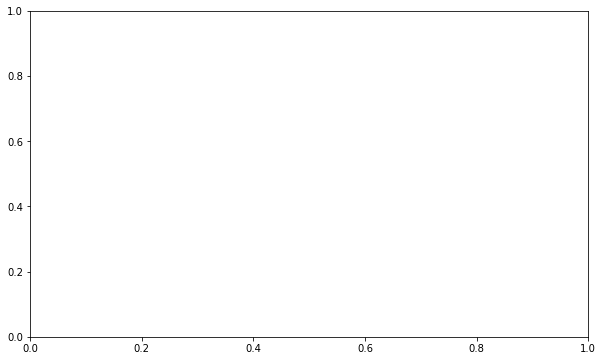

In [29]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

ax.hist(coherence_vec, range=[0, 0.0008], bins=100)
ymax = ax.get_ybound()
ax.vlines(true_coherence, ymin=0, ymax=ymax[1], color='r')
ax.set_title('standard, no forced correlation')
ax.set_xlabel('Coherence')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

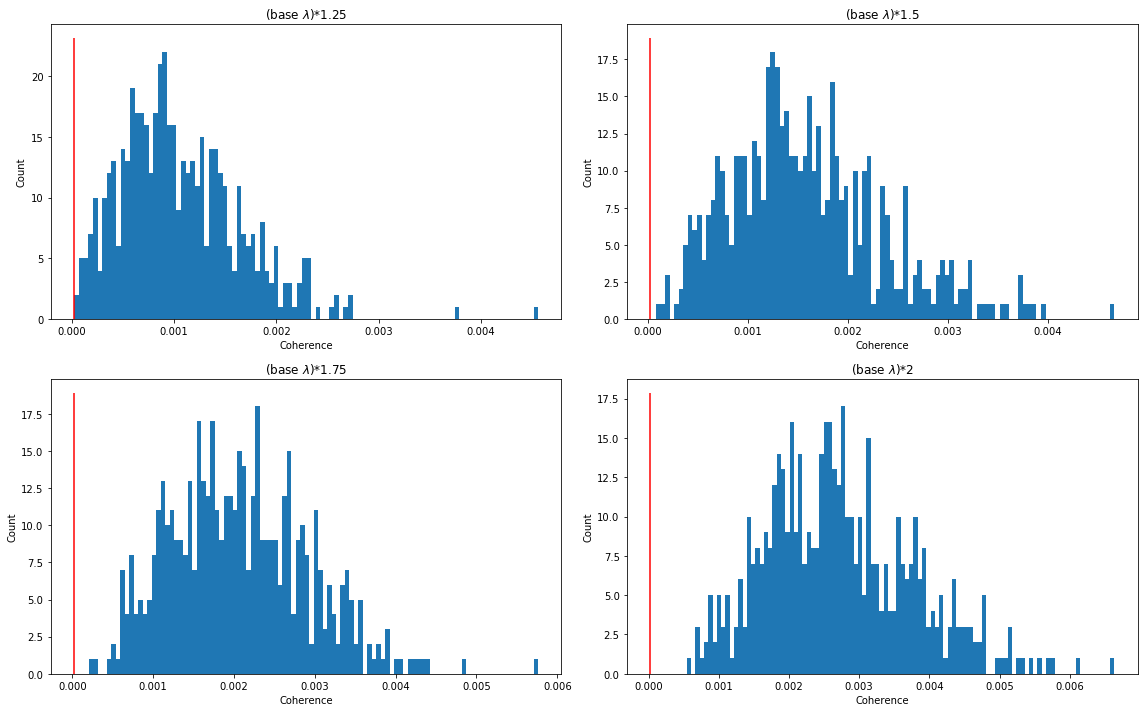

In [41]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(16,10))

for ax, i, s in zip(axes.flatten(), range(len(lambdas)), scale):
    ax.hist(coherence_mat[:,i], bins=100)
    ymax = ax.get_ybound()
    ax.vlines(true_coherence, ymin=0, ymax=ymax[1], color='r')
    ax.set_title(r'(base $\lambda$)*{}'.format(s))
    ax.set_ylabel('Count')
    ax.set_xlabel('Coherence')
plt.tight_layout()
plt.show()

In [42]:
test_mat = np.loadtxt('sim_results/coherence_mat.txt')
sum(coherence_mat == test_mat)

array([500, 500, 500, 500])

In [43]:
test_vec = np.loadtxt('sim_results/null_sim.txt')
sum(coherence_vec == test_vec)

10000

# Calculate power

The procedure below calculates the power for the different values of $\lambda$.

In [44]:
# load in from .txt, don't need to run sims over and over
alt_mat = np.loadtxt('sim_results/coherence_mat.txt')

## this is the only sim i ran for 10k so far
null = np.loadtxt('sim_results/null_sim_10k.txt')

In [45]:
def power_calc(null_vec, alt_vec, sd_away=2):
    # power is the probability rejecting the null when you should reject
    # null: the distribution with forced correlation is identical to the one without forced correlation
    # alternative: the distribution with forced correlation is different
    
    # create empty vector of rejections
    reject_list = np.empty(shape=len(alt_vec))
    
    # get quantile value from null sim (reference distribution)
    alpha = scipy.stats.norm.pdf(sd_away)
    co_q = np.quantile(null_vec, q=1-alpha)
    
    # compare each value of alt vec to quantile
    for i, co in enumerate(alt_vec):
        reject_list[i] = 1*(co >= co_q)

    return np.mean(reject_list)

In [46]:
sd_away_vec = [2,3,5]
for i, s in enumerate(scale):
    for sd_away in sd_away_vec:
        print('lambda*{},'.format(s), 'n={},'.format(nsim), 'sigma={},'.format(sd_away),
              'Power={}'.format( power_calc(null_vec=null, alt_vec=alt_mat[:,i], sd_away=sd_away) ))

lambda*1.25, n=500, sigma=2, Power=0.932
lambda*1.25, n=500, sigma=3, Power=0.726
lambda*1.25, n=500, sigma=5, Power=0.35
lambda*1.5, n=500, sigma=2, Power=0.988
lambda*1.5, n=500, sigma=3, Power=0.9
lambda*1.5, n=500, sigma=5, Power=0.66
lambda*1.75, n=500, sigma=2, Power=0.996
lambda*1.75, n=500, sigma=3, Power=0.974
lambda*1.75, n=500, sigma=5, Power=0.826
lambda*2, n=500, sigma=2, Power=1.0
lambda*2, n=500, sigma=3, Power=0.998
lambda*2, n=500, sigma=5, Power=0.944
